# OSAS Detection: Transformer Model Architecture Analysis

This notebook provides a model architecture analysis of the Transformer-based Obstructive Sleep Apnea Syndrome (OSAS) detection project.

---

In [1]:
# Import required libraries
import os
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import graphviz
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")
print("Working directory:", os.getcwd())

Libraries imported successfully!
Working directory: /workspace/philix/osas/osas_detection


## 1. Project Analysis and Code Parsing

Let's start by analyzing the code structure and extracting key architectural details from the Python files.

In [2]:
class CodeParser:
    """Parser to extract architectural information from Python files."""
    
    def __init__(self, project_path="."):
        self.project_path = project_path
        self.files = {
            'model': 'model.py',
            'preprocess': 'preprocess_data.py', 
            'train': 'train_model.py',
            'dataset': 'dataset.py'
        }
        self.architecture_info = {}
    
    def parse_model_architecture(self):
        """Extract model architecture details from model.py"""
        try:
            with open(self.files['model'], 'r') as f:
                content = f.read()
            
            # Parse class definitions and key parameters
            tree = ast.parse(content)
            
            model_info = {
                'classes': [],
                'key_parameters': {},
                'input_modalities': [],
                'model_components': []
            }
            
            for node in ast.walk(tree):
                if isinstance(node, ast.ClassDef):
                    model_info['classes'].append(node.name)
                    
                elif isinstance(node, ast.FunctionDef) and node.name == '__init__':
                    # Extract initialization parameters
                    if hasattr(node, 'args') and node.args.args:
                        params = [arg.arg for arg in node.args.args[1:]]  # Skip 'self'
                        model_info['key_parameters'][node.lineno] = params
            
            # Extract specific architectural details
            if 'MultiModalEncoder' in content:
                model_info['input_modalities'] = ['vital_signs', 'waveforms', 'psg_signals']
            
            if 'TransformerEncoder' in content:
                model_info['model_components'].append('Transformer Encoder')
            
            if 'PositionalEncoding' in content:
                model_info['model_components'].append('Positional Encoding')
                
            self.architecture_info['model'] = model_info
            return model_info
            
        except Exception as e:
            print(f"Error parsing model.py: {e}")
            return {}
    
    def parse_preprocessing_pipeline(self):
        """Extract preprocessing information"""
        try:
            with open(self.files['preprocess'], 'r') as f:
                content = f.read()
            
            preprocess_info = {
                'filters': [],
                'window_params': {},
                'signal_types': []
            }
            
            # Extract filter information
            if 'Butterworth' in content:
                preprocess_info['filters'].append('Butterworth Bandpass Filter')
            
            # Extract signal types
            if 'vital_columns' in content:
                preprocess_info['signal_types'].extend(['HR', 'SpO2', 'PI', 'RR', 'PVCs'])
            
            if 'waveform_columns' in content:
                preprocess_info['signal_types'].extend(['ECG-I', 'ECG-II', 'ECG-III', 'PPG'])
                
            if 'psg_columns' in content:
                preprocess_info['signal_types'].extend(['PSG Flow', 'PSG Snore', 'PSG Position', 'PSG Thorax', 'PSG Abdomen'])
            
            self.architecture_info['preprocess'] = preprocess_info
            return preprocess_info
            
        except Exception as e:
            print(f"Error parsing preprocess_data.py: {e}")
            return {}
    
    def get_model_config(self):
        """Extract default model configuration"""
        config = {
            'vital_dim': 5,
            'waveform_channels': 4,
            'waveform_length': 80,
            'psg_channels': 5,
            'psg_lengths': [20, 10, 10, 10, 10],
            'd_model': 256,
            'nhead': 8,
            'num_encoder_layers': 6,
            'dim_feedforward': 1024,
            'dropout': 0.1,
            'window_size': 60,
            'tasks': ['binary', 'multiclass', 'multitask']
        }
        return config

# Initialize parser and extract information
parser = CodeParser()
model_info = parser.parse_model_architecture()
preprocess_info = parser.parse_preprocessing_pipeline()
config = parser.get_model_config()

print("Code Analysis Complete!")
print(f"Model Classes Found: {model_info.get('classes', [])}")
print(f"Input Modalities: {model_info.get('input_modalities', [])}")
print(f"Model Components: {model_info.get('model_components', [])}")
print(f"Signal Types: {len(preprocess_info.get('signal_types', []))} types identified")

Code Analysis Complete!
Model Classes Found: ['PositionalEncoding', 'MultiModalEncoder', 'OSASTransformer', 'OSASMultiTaskTransformer']
Input Modalities: ['vital_signs', 'waveforms', 'psg_signals']
Model Components: ['Transformer Encoder', 'Positional Encoding']
Signal Types: 14 types identified


In [3]:
# Create detailed parameter analysis table
def create_parameter_table():
    """Create a comprehensive table of model parameters"""
    
    data = {
        'Component': [
            'Vital Signs Encoder',
            'Waveform Encoder (Conv1D)',
            'PSG Signal Encoders',
            'Transformer Encoder',
            'Positional Encoding',
            'Binary Classifier',
            'Multiclass Classifier',
            'Input Window'
        ],
        'Input Shape': [
            '(batch, 60, 5)',
            '(batch, 60, 80, 4)',
            '(batch, 60, [20,10,10,10,10], 5)',
            '(batch, seq_len, 256)',
            '(batch, seq_len, 256)',
            '(batch, 256)',
            '(batch, 256)',
            '60 seconds'
        ],
        'Output Shape': [
            '(batch, 60, 256)',
            '(batch, 60, 256)',
            '(batch, 60, 256)',
            '(batch, seq_len, 256)',
            '(batch, seq_len, 256)',
            '(batch, 2)',
            '(batch, 5)',
            'Windowed data'
        ],
        'Key Parameters': [
            'Linear(5 → 256)',
            'Conv1D(4→64→128) + AdaptivePool',
            '5x Conv1D(1→32) per PSG channel',
            f'{config["num_encoder_layers"]} layers, {config["nhead"]} heads',
            f'max_len=5000, dropout={config["dropout"]}',
            'Linear(256 → 512 → 2)',
            'Linear(256 → 512 → 5)',
            f'{config["window_size"]}s, 50% overlap'
        ],
        'Purpose': [
            'Encode vital sign time series',
            'Extract waveform features via CNN',
            'Process PSG signals separately',
            'Multi-head self-attention',
            'Add temporal position info',
            'Binary anomaly detection',
            'Event type classification',
            'Temporal segmentation'
        ]
    }
    
    df = pd.DataFrame(data)
    return df

param_df = create_parameter_table()

# Display with styling
print("Model Architecture Parameters:")
print("=" * 80)
display(param_df.style.set_properties(**{
    'background-color': '#f0f0f0',
    'color': 'black',
    'border-color': 'white'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#4CAF50'), ('color', 'white')]},
    {'selector': 'td', 'props': [('text-align', 'left')]}
]))

Model Architecture Parameters:


,Component,Input Shape,Output Shape,Key Parameters,Purpose
0,Vital Signs Encoder,"(batch, 60, 5)","(batch, 60, 256)",Linear(5 → 256),Encode vital sign time series
1,Waveform Encoder (Conv1D),"(batch, 60, 80, 4)","(batch, 60, 256)",Conv1D(4→64→128) + AdaptivePool,Extract waveform features via CNN
2,PSG Signal Encoders,"(batch, 60, [20,10,10,10,10], 5)","(batch, 60, 256)",5x Conv1D(1→32) per PSG channel,Process PSG signals separately
3,Transformer Encoder,"(batch, seq_len, 256)","(batch, seq_len, 256)","6 layers, 8 heads",Multi-head self-attention
4,Positional Encoding,"(batch, seq_len, 256)","(batch, seq_len, 256)","max_len=5000, dropout=0.1",Add temporal position info
5,Binary Classifier,"(batch, 256)","(batch, 2)",Linear(256 → 512 → 2),Binary anomaly detection
6,Multiclass Classifier,"(batch, 256)","(batch, 5)",Linear(256 → 512 → 5),Event type classification
7,Input Window,60 seconds,Windowed data,"60s, 50% overlap",Temporal segmentation


## 2. Model Architecture Visualization

Model Architecture Diagram Generated!
Graphviz diagram with detailed component flow


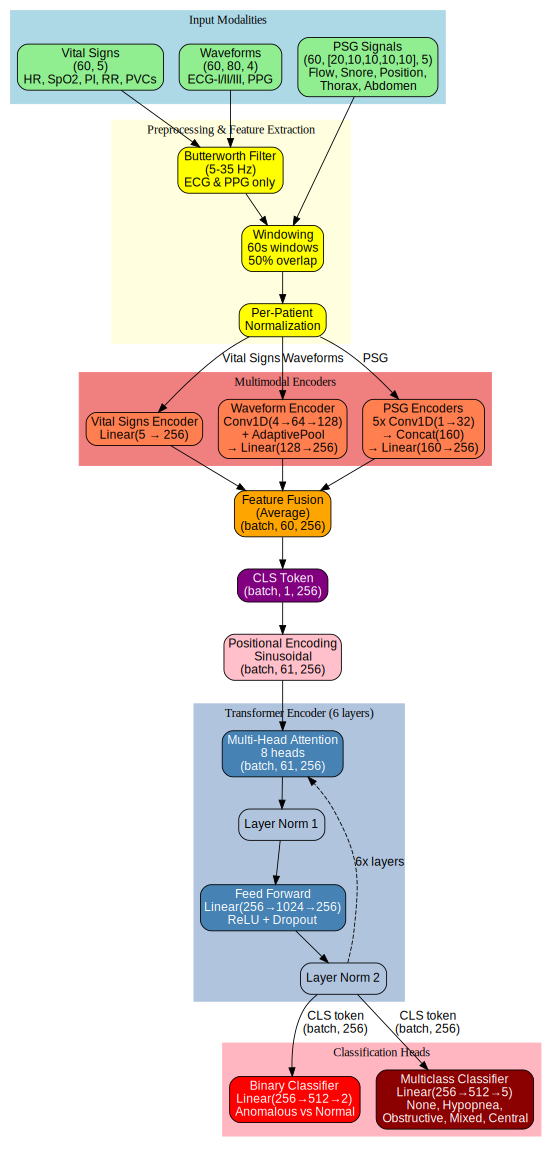

In [4]:
def create_graphviz_architecture():
    """Create a comprehensive Graphviz diagram of the model architecture"""
    
    dot = graphviz.Digraph(comment='OSAS Transformer Architecture')
    dot.attr(rankdir='TB', size='12,16')
    dot.attr('node', shape='box', style='rounded,filled', fontname='Arial')
    dot.attr('edge', fontname='Arial')
    
    # Input Layer
    with dot.subgraph(name='cluster_input') as input_cluster:
        input_cluster.attr(label='Input Modalities', style='filled', color='lightblue')
        input_cluster.node('vital', 'Vital Signs\n(60, 5)\nHR, SpO2, PI, RR, PVCs', fillcolor='lightgreen')
        input_cluster.node('waveforms', 'Waveforms\n(60, 80, 4)\nECG-I/II/III, PPG', fillcolor='lightgreen')
        input_cluster.node('psg', 'PSG Signals\n(60, [20,10,10,10,10], 5)\nFlow, Snore, Position,\nThorax, Abdomen', fillcolor='lightgreen')
    
    # Preprocessing Layer
    with dot.subgraph(name='cluster_preprocess') as preprocess_cluster:
        preprocess_cluster.attr(label='Preprocessing & Feature Extraction', style='filled', color='lightyellow')
        preprocess_cluster.node('filter', 'Butterworth Filter\n(5-35 Hz)\nECG & PPG only', fillcolor='yellow')
        preprocess_cluster.node('window', 'Windowing\n60s windows\n50% overlap', fillcolor='yellow')
        preprocess_cluster.node('normalize', 'Per-Patient\nNormalization', fillcolor='yellow')
    
    # Encoder Layer
    with dot.subgraph(name='cluster_encoder') as encoder_cluster:
        encoder_cluster.attr(label='Multimodal Encoders', style='filled', color='lightcoral')
        encoder_cluster.node('vital_enc', 'Vital Signs Encoder\nLinear(5 → 256)', fillcolor='coral')
        encoder_cluster.node('wave_enc', 'Waveform Encoder\nConv1D(4→64→128)\n+ AdaptivePool\n→ Linear(128→256)', fillcolor='coral')
        encoder_cluster.node('psg_enc', 'PSG Encoders\n5x Conv1D(1→32)\n→ Concat(160)\n→ Linear(160→256)', fillcolor='coral')    
    # Feature Fusion
    dot.node('fusion', 'Feature Fusion\n(Average)\n(batch, 60, 256)', fillcolor='orange')
    
    # CLS Token
    dot.node('cls', 'CLS Token\n(batch, 1, 256)', fillcolor='purple', fontcolor='white')
    
    # Positional Encoding
    dot.node('pos_enc', 'Positional Encoding\nSinusoidal\n(batch, 61, 256)', fillcolor='pink')
    
    # Transformer Block
    with dot.subgraph(name='cluster_transformer') as transformer_cluster:
        transformer_cluster.attr(label='Transformer Encoder (6 layers)', style='filled', color='lightsteelblue')
        transformer_cluster.node('mha', 'Multi-Head Attention\n8 heads\n(batch, 61, 256)', fillcolor='steelblue', fontcolor='white')
        transformer_cluster.node('ffn', 'Feed Forward\nLinear(256→1024→256)\nReLU + Dropout', fillcolor='steelblue', fontcolor='white')
        transformer_cluster.node('norm1', 'Layer Norm 1', fillcolor='lightsteelblue')
        transformer_cluster.node('norm2', 'Layer Norm 2', fillcolor='lightsteelblue')
    
    # Classification Heads
    with dot.subgraph(name='cluster_output') as output_cluster:
        output_cluster.attr(label='Classification Heads', style='filled', color='lightpink')
        output_cluster.node('binary_head', 'Binary Classifier\nLinear(256→512→2)\nAnomalous vs Normal', fillcolor='red', fontcolor='white')
        output_cluster.node('multi_head', 'Multiclass Classifier\nLinear(256→512→5)\nNone, Hypopnea,\nObstructive, Mixed, Central', fillcolor='darkred', fontcolor='white')
    
    # Connections - Input to Preprocessing
    dot.edge('vital', 'filter')
    dot.edge('waveforms', 'filter')
    dot.edge('psg', 'window')
    dot.edge('filter', 'window')
    dot.edge('window', 'normalize')
    
    # Preprocessing to Encoders
    dot.edge('normalize', 'vital_enc', label='Vital Signs')
    dot.edge('normalize', 'wave_enc', label='Waveforms')
    dot.edge('normalize', 'psg_enc', label='PSG')
    
    # Encoders to Fusion
    dot.edge('vital_enc', 'fusion')
    dot.edge('wave_enc', 'fusion')
    dot.edge('psg_enc', 'fusion')
    
    # Fusion to Transformer
    dot.edge('fusion', 'cls')
    dot.edge('cls', 'pos_enc')
    dot.edge('pos_enc', 'mha')
    
    # Transformer internal connections
    dot.edge('mha', 'norm1')
    dot.edge('norm1', 'ffn')
    dot.edge('ffn', 'norm2')
    dot.edge('norm2', 'mha', style='dashed', label='6x layers')
    
    # Output connections
    dot.edge('norm2', 'binary_head', label='CLS token\n(batch, 256)')
    dot.edge('norm2', 'multi_head', label='CLS token\n(batch, 256)')
    
    return dot

# Create and display the diagram
architecture_diagram = create_graphviz_architecture()
print("Model Architecture Diagram Generated!")
print("Graphviz diagram with detailed component flow")

# Display the diagram
try:
    display(architecture_diagram)
except Exception as e:
    print(f"Graphviz rendering issue: {e}")
    print("Diagram source code:")
    print(architecture_diagram.source)